### Unidad 1: Taller de resolución de problemas de clasificación automática

<h1> Notebook 2 - Logistic Regression from Scratch in Python</h1>

Tutorial realizado por Nick Becker (NVIDIA): https://beckernick.github.io/logistic-regression-from-scratch/

In this post, I'm going to walk through implementig basic binary logistic regression from scratch. Logistic regression is a generalized linear model that we can use to model or predict categorical outcome variables. We might use logistic regression to predict whether someone will be denied or approved for a loan, but probably not to predict the value of someone's house.

So, how does it work? In logistic regression, we're essentially trying to find the weights that maximize the likelihood of producing our given data. Maximum Likelihood Estimation is a well covered topic in statistics courses (my Intro to Statistics professor from sophomore year of college has a straightforward, high-level description [here](http://www2.stat.duke.edu/~banks/111-lectures.dir/lect10.pdf)), and it is extremely useful.

Since this maximizing the likelihood is an iterative process, I'll solve the optimization problem with gradient descent. Before I do that, though, I need some data.

# Generating Data
Like in my post on [building neural networks from scratch](https://beckernick.github.io/neural-network-scratch/), I'm going to use simulated data. I can easily simulate separable data by sampling from a multivariate normal distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(12)
num_observations = 5000

x1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)

simulated_separableish_features = np.vstack((x1, x2)).astype(np.float32)
simulated_labels = np.hstack((np.zeros(num_observations),
                              np.ones(num_observations)))

 <div style="color:red">
    COMENTARIOS:
 <li>
     <ul>Los datos están generados de manera aleatoria siguiendo una distribución normal.</ul>
    <ul>Los datos tienen 2 caractéristicas x1 y x2.</ul>
    <ul> 2 variables: una para las caracteristicas y una para los labels.</ul>
    </li>
 </div> 

Let's see how it looks.

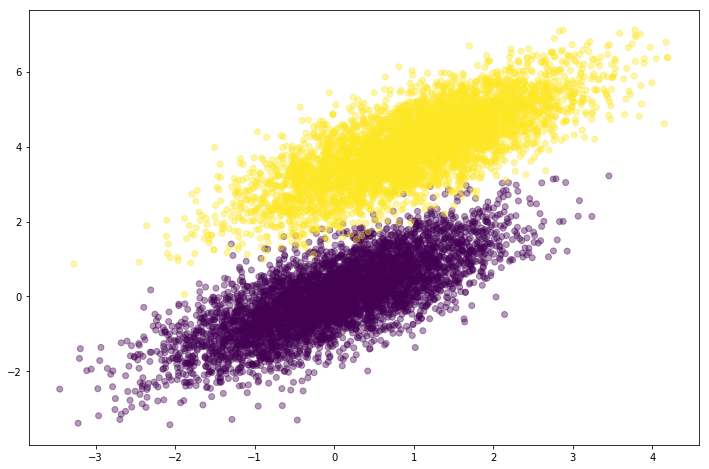

In [2]:
plt.figure(figsize=(12,8))
plt.scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = simulated_labels, alpha = .4)

# Picking a Link Function
Generalized linear models usually tranform a linear model of the predictors by using a [link function](https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function). In logistic regression, the link function is the [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function). We can implement this really easily.

In [3]:
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))

# Maximizing the Likelihood

To maximize the likelihood, I need a way to compute the likelihood and the gradient of the likelihood. Fortunately, the likelihood (for binary classification) can be reduced to a fairly intuitive form by switching to the log-likelihood. We're able to do this without affecting the weights parameter estimation because log transformation are [monotonic](https://en.wikipedia.org/wiki/Monotonic_function).

For anyone interested in the derivations of the functions I'm using, check out Section 4.4.1 of Hastie, Tibsharani, and Friedman's [Elements of Statistical Learning](http://statweb.stanford.edu/~tibs/ElemStatLearn/). For those less mathematically inclined, Carlos Guestrin (Univesity of Washington) details one possible derivation of the log-likelihood in a series of short lectures on [Coursera](https://www.coursera.org/learn/ml-classification/lecture/1ZeTC/very-optional-expressing-the-log-likelihood) using indicator functions.

## Calculating the Log-Likelihood

The log-likelihood can be viewed as as sum over all the training data. Mathematically,

$$\begin{equation}
ll = \sum_{i=1}^{N}y_{i}\beta ^{T}x_{i} - log(1+e^{\beta^{T}x_{i}})
\end{equation}$$

where $y$ is the target class, $x_{i}$ represents an individual data point, and $\beta$ is the weights vector.

I can easily turn that into a function and take advantage of matrix algebra.

In [4]:
def log_likelihood(features, target, weights):
    scores = np.dot(features, weights)
    ll = np.sum( target*scores - np.log(1 + np.exp(scores)) )
    return ll

## Calculating the Gradient

Now I need an equation for the gradient of the log-likelihood. By taking the derivative of the equation above and reformulating in matrix form, the gradient becomes: 

$$\begin{equation}
\bigtriangledown ll = X^{T}(Y - Predictions)
\end{equation}$$

Again, this is really easy to implement. It's so simple I don't even need to wrap it into a function. The gradient here looks very similar to the output layer gradient in a neural network (see my [post](https://beckernick.github.io/neural-network-scratch/) on neural networks if you're curious).

This shouldn't be too surprising, since a neural network is basically just a series of non-linear link functions applied after linear manipulations of the input data.

# Building the Logistic Regression Function

Finally, I'm ready to build the model function. I'll add in the option to calculate the model with an intercept, since it's a good option to have.

In [5]:
def logistic_regression(features, target, num_steps, learning_rate, add_intercept = False):
    if add_intercept:
        intercept = np.ones((features.shape[0], 1))
        features = np.hstack((intercept, features))
        
    weights = np.zeros(features.shape[1])
    
    for step in range(num_steps):
        scores = np.dot(features, weights)
        predictions = sigmoid(scores)

        # Update weights with log likelihood gradient
        output_error_signal = target - predictions
        
        gradient = np.dot(features.T, output_error_signal)
        weights += learning_rate * gradient

        # Print log-likelihood every so often
        if step % 10000 == 0:
            print(log_likelihood(features, target, weights))
        
    return weights

Time to do the regression.

In [6]:
weights = logistic_regression(simulated_separableish_features, simulated_labels,
                     num_steps = 50000, learning_rate = 5e-5, add_intercept=True)

-4346.264779152365
-148.7067227680535
-142.9649362310784
-141.5453030715737
-141.06031965930796


In [7]:
print(weights)

[-13.58690551  -4.8809644    7.99812915]


# Comparing to Sk-Learn's LogisticRegression
How do I know if my algorithm spit out the right weights? Well, one the one hand, the math looks right -- so I should be confident it's correct.

Fortunately, I can compare my functions' weights to the weights from sk-learn's logistic regression function, which is known to be a correct implementation. They should be the same if I did everything correctly. Since sk-learn's `LogisticRegression` automatically regularizes (which I didn't do), I set `C=1e15` to essentially turn off regularization.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

clf = LogisticRegression(fit_intercept=True, C = 1e15)
clf.fit(simulated_separableish_features, simulated_labels)

/home/mvernier/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1000000000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [14]:
print(clf.intercept_, clf.coef_)
print(weights)

[-13.99400797] [[-5.02712572  8.23286799]]
[-13.58690551  -4.8809644    7.99812915]


As expected, my weights nearly perfectly match the sk-learn `LogisticRegression` weights. If I trained the algorithm longer and with a small enough learning rate, they would eventually match exactly. Why? Because gradient descent on a convex function will always reach the global optimum, given enough time and sufficiently small learning rate.

# What's the Accuracy?
To get the accuracy, I just need to use the final weights to get the logits for the dataset (`final_scores`). Then I can use `sigmoid` to get the final predictions and round them to the nearest integer (0 or 1) to get the predicted class.

In [15]:
final_scores = np.dot(np.hstack((np.ones((simulated_separableish_features.shape[0], 1)),
                                 simulated_separableish_features)), weights)
preds = np.round(sigmoid(final_scores))

print('Accuracy from scratch: {0}'.format((preds == simulated_labels).sum().astype(float) / len(preds)))
print('Accuracy from sk-learn: {0}'.format(clf.score(simulated_separableish_features, simulated_labels)))

Accuracy from scratch: 0.9948
Accuracy from sk-learn: 0.9948


Nearly perfect (which makes sense given the data). We should only have made mistakes right in the middle between the clusters. Let's make sure that's what happened. In the following plot, blue points are correct predictions, and red points are incorrect

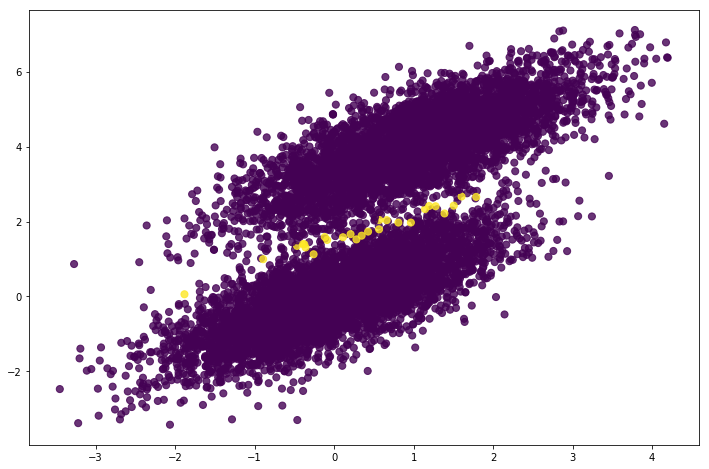

In [16]:
plt.figure(figsize = (12, 8))
plt.scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = preds == simulated_labels - 1, alpha = .8, s = 50)

# Conclusion

In this post, I built a logistic regression function from scratch and compared it with sk-learn's logistic regression function. While both functions give essentially the same result, my own function is **_significantly_** slower because it uses a highly optimized solver. While I'd probably never use my own algorithm in production, building algorithms from scratch makes it easier to think about how you could extend the algorithm to fit problems in new domains.